In [1]:
!pip install -r requirements.txt

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# Problem Statement - TSF Project
## Context
As an analyst at ABC Estate Wines, we are presented with historical data encompassing the sales of different types of wines throughout the 20th century. These datasets originate from the same company but represent sales figures for distinct wine varieties. Our objective is to delve into the data, analyze trends, patterns, and factors influencing wine sales over the course of the century. By leveraging data analytics and forecasting techniques, we aim to gain actionable insights that can inform strategic decision-making and optimize sales strategies for the future.

## Objective
The primary objective of this project is to analyze and forecast wine sales trends for the 20th century based on historical data provided by ABC Estate Wines. We aim to equip ABC Estate Wines with the necessary insights and foresight to enhance sales performance, capitalize on emerging market opportunities, and maintain a competitive edge in the wine industry.


## Question 1: Define the problem and perform Exploratory Data Analysis
- Read the data as an appropriate time series data - Plot the data - Perform EDA - Perform Decomposition
### Define the problem
We have been given wine sales data for Rose and Sparkling Wine, for one company from 1980 to 1995, we need to look at the historical trends and predict the forcast for future sales for both these varieties of wine.
### Read the data as an appropriate time series data
- The data is given to us monthly, from 1980 to 1995.

In [3]:
df_sparkling = pd.read_csv('./data/Sparkling.csv', parse_dates=['YearMonth'], index_col='YearMonth')
print("Data Loaded:")
print(df_sparkling.head())
df_rose = pd.read_csv('./data/Rose.csv', parse_dates=['YearMonth'], index_col='YearMonth')
print("Data Loaded:")
print(df_rose.head())

Data Loaded:
            Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471
Data Loaded:
             Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0


### ploting the data
- Observations
    - Sparkling Sales are much higher than Rose, and shows seasonality but trend looks flat.
    - Rose Sales looks flat but could be due to scaling onthe same plot we will plot Rose Seperately.
    - Sperate plot of Rose shows a potiential declining trend and some missing values around 1995 which we will have to treat.

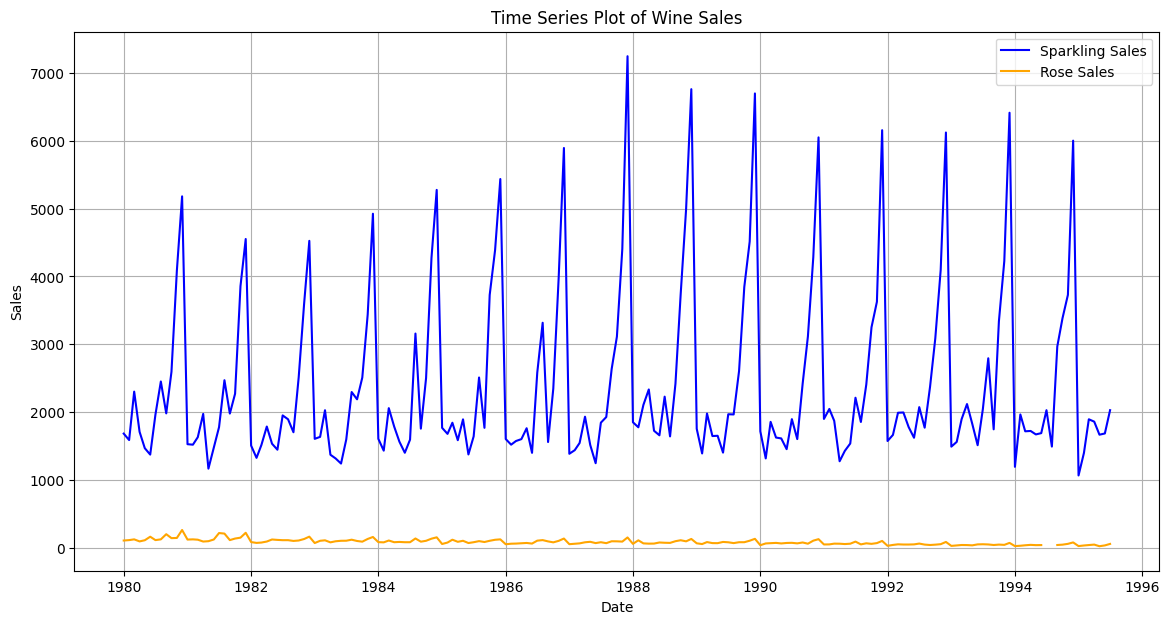

In [4]:
plt.figure(figsize=(14, 7))
plt.plot(df_sparkling['Sparkling'], label='Sparkling Sales', color='blue')
plt.plot(df_rose['Rose'], label='Rose Sales', color='orange')
plt.title('Time Series Plot of Wine Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.savefig('./images/Time_Plot_all.svg')
plt.show()

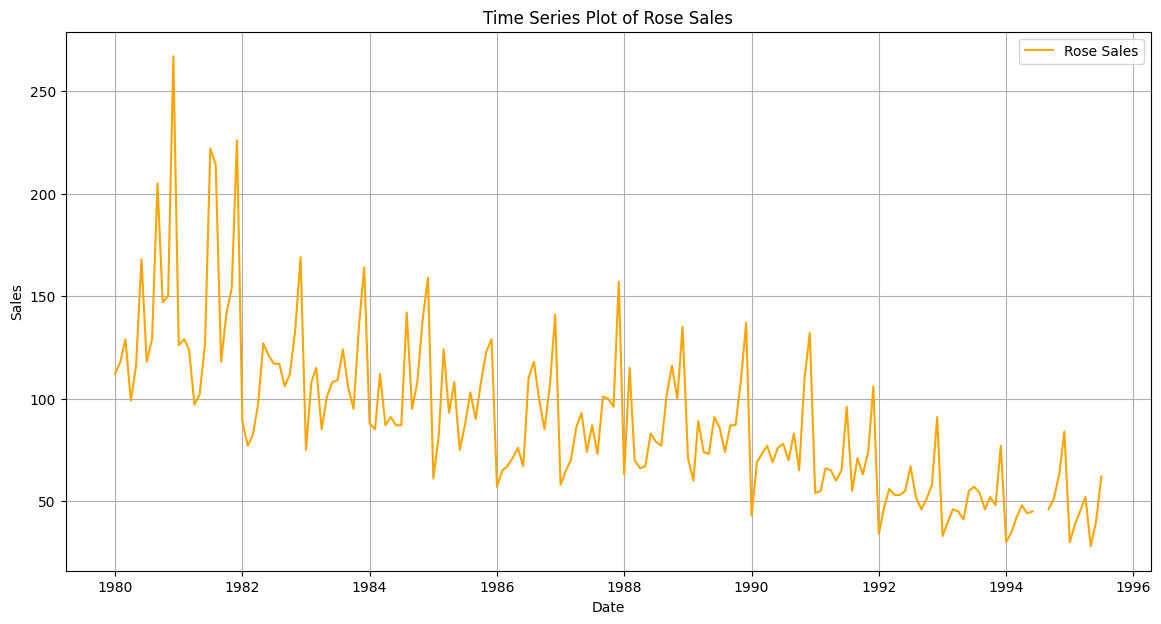

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(df_rose['Rose'], label='Rose Sales', color='orange')
plt.title('Time Series Plot of Rose Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.savefig('./images/Time_Plot_Rose.svg')
plt.show()

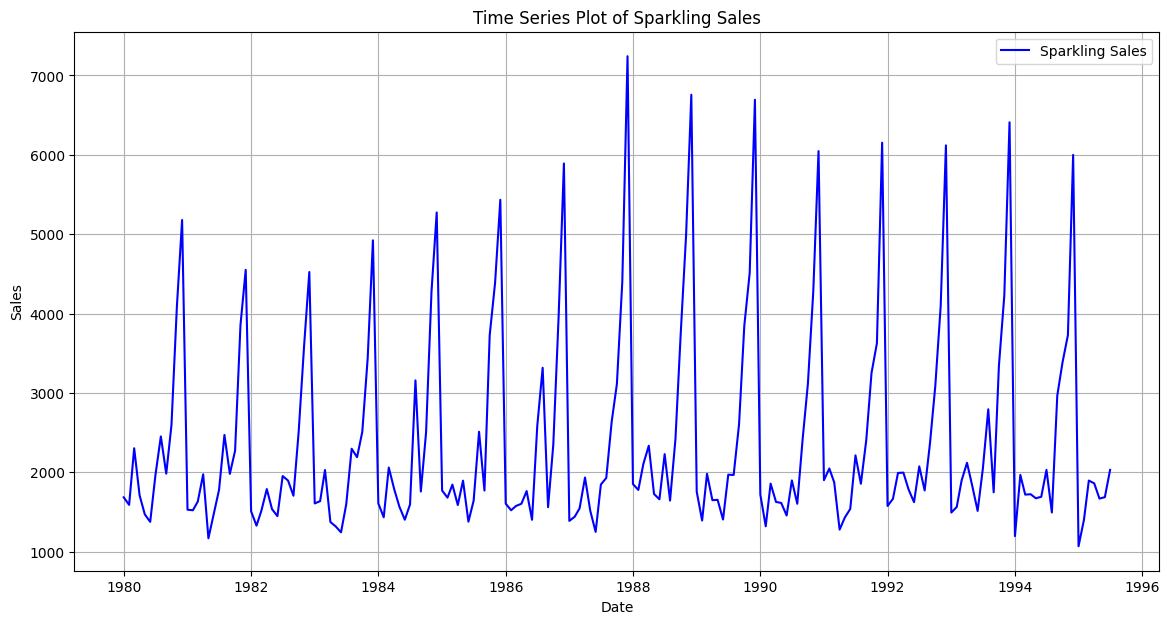

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(df_sparkling['Sparkling'], label='Sparkling Sales', color='blue')
plt.title('Time Series Plot of Sparkling Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.savefig('./images/Time_Plot_spark.svg')
plt.show()

### Perform Exploratory Data Analysis (EDA)
- Lets do a describe, histogram and box plot.
- Also box plt between years and same months acoss years to see if there is any trends
- Descibe
    - Sparkling: has much higher sales with 1874 as the median, with long tails 1070 min and 7242 max, and possible outliers
    - Rose: has more modest sales with 86 as the median, it too seems to have long tails and possible outliers
-Histogram, Boxplots and Trends:
    - Sparkling: Histogram is uniform across the months and show that the distribution is not normal, boxplot between the years  shows there was a dip between 1980 to 1982, 1983 to 1985 is pretty flat with a fall in 1986 followed by a climb to 1988 and a fall again till 1990, flat from 1991 to 1993, followed but a fall in 1944 and 1995, there seems to be trend every three years, boxplot between the month across years, shows a sligth rise in March and April, followed by a step rise from july to december, The line plot by month split on years shows the similar trend to the box plots but more clearly, The rolling mean and standard deviation are flat across the years.
    - Rose: Histogram is uniform across the months and show that the distribution is not normal, boxplot between the years clearly shows a steady decline in sales through the years with a steep fall since 1990, boxplot between the month across years, shows sales remain flat in the mid months from April to June, with a rise in July to the end of the year and aslo a rise from January to March, The line plot by month split by year show no distinct trend in the recent years, The rolling mean and standard deviation are in a downward trend across the years.
  

In [7]:
print("\nSparkling Summary Statistics:")
print(df_sparkling.describe())

print("\nRose Summary Statistics:")
print(df_rose.describe())


Sparkling Summary Statistics:
         Sparkling
count   187.000000
mean   2402.417112
std    1295.111540
min    1070.000000
25%    1605.000000
50%    1874.000000
75%    2549.000000
max    7242.000000

Rose Summary Statistics:
             Rose
count  185.000000
mean    90.394595
std     39.175344
min     28.000000
25%     63.000000
50%     86.000000
75%    112.000000
max    267.000000


In [8]:
df_sparkling = df_sparkling.reset_index()
df_sparkling['Year'] = df_sparkling['YearMonth'].dt.year

df_rose = df_rose.reset_index()
df_rose['Year'] = df_rose.reset_index()['YearMonth'].dt.year

df_sparkling['Month'] = df_sparkling['YearMonth'].dt.month
df_rose['Month'] = df_rose['YearMonth'].dt.month


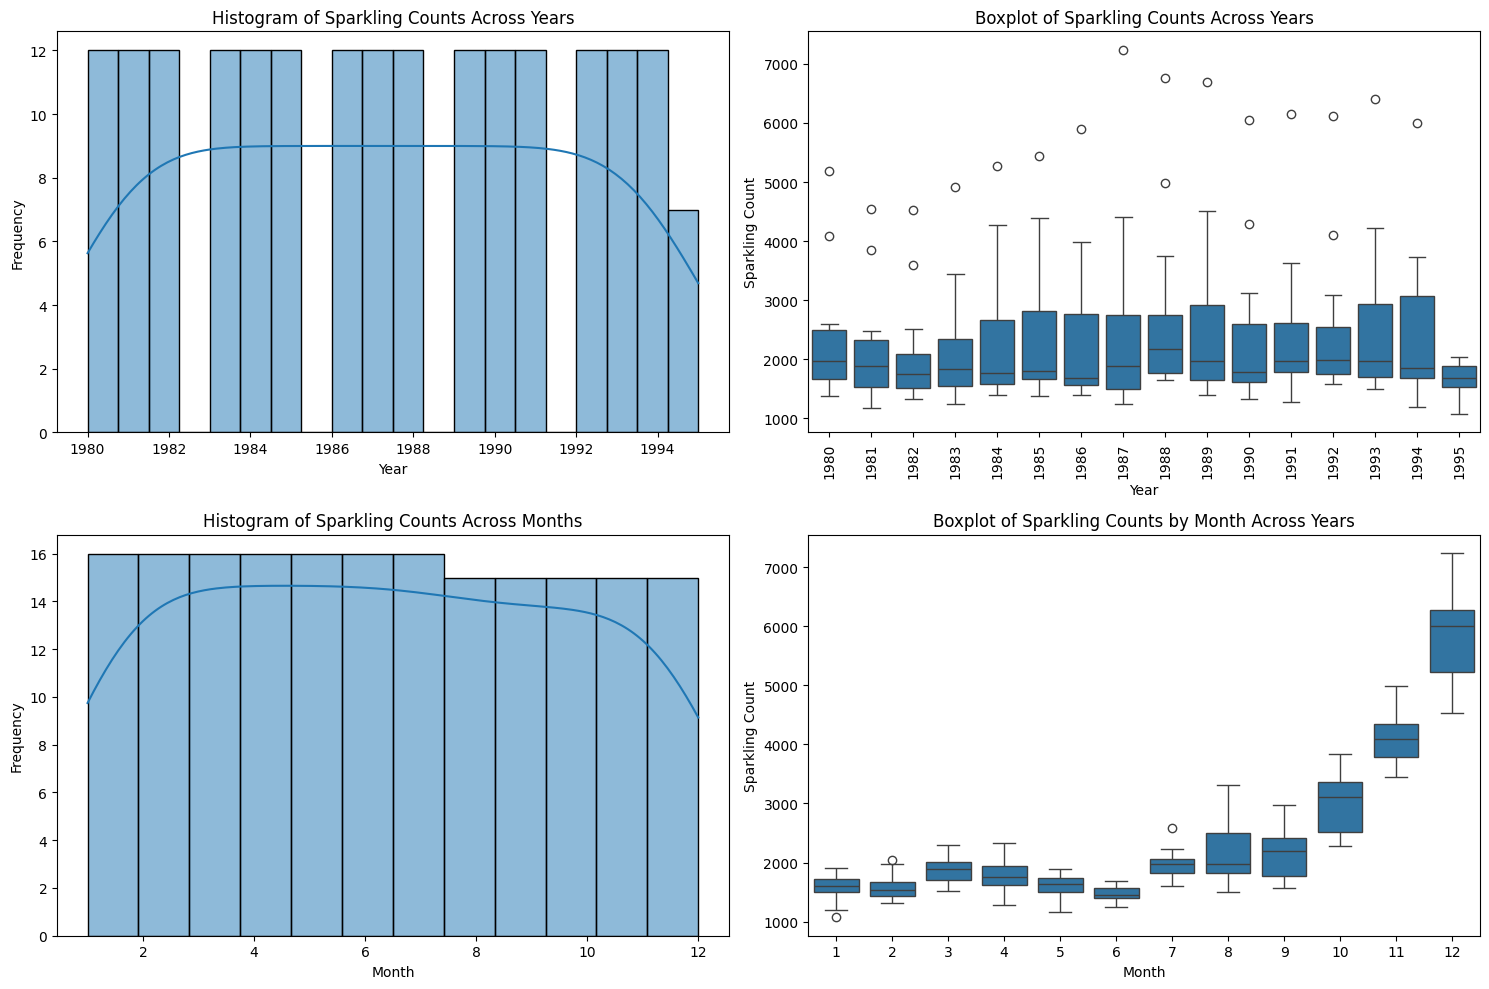

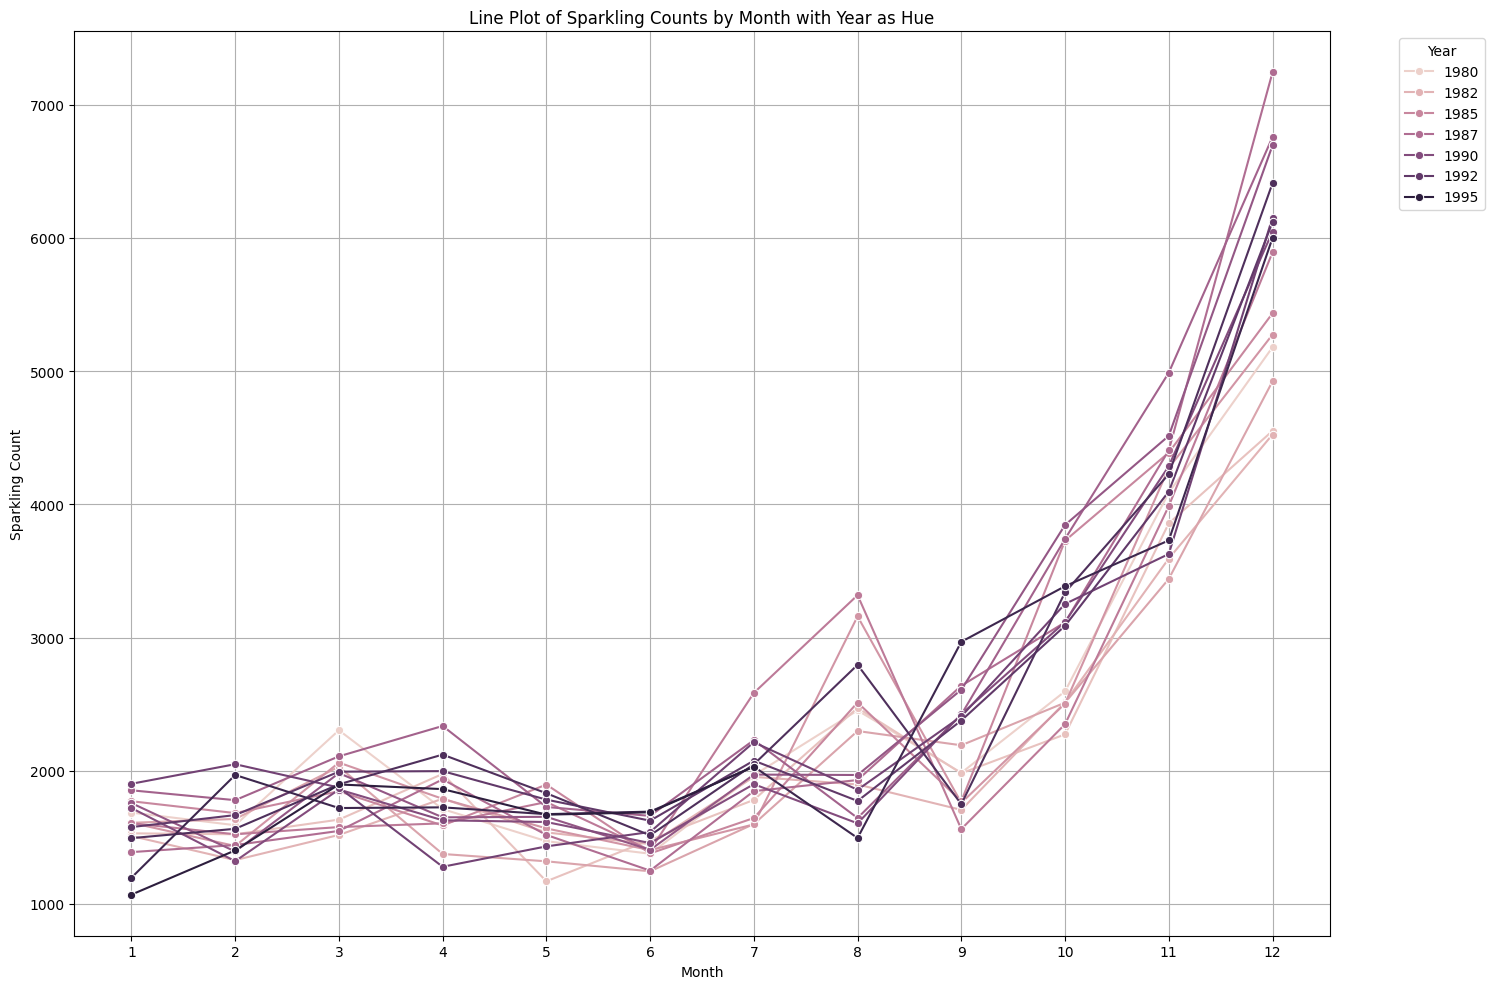

In [9]:


# Histogram across years Sparkling

plt.figure(figsize=(15, 10))

# Histogram across years
plt.subplot(2, 2, 1)
sns.histplot(data=df_sparkling, x='Year', bins=20, kde=True)
plt.title('Histogram of Sparkling Counts Across Years')
plt.xlabel('Year')
plt.ylabel('Frequency')

# Boxplot across years
plt.subplot(2, 2, 2)
sns.boxplot(x='Year', y='Sparkling', data=df_sparkling)
plt.xticks(rotation=90)
plt.title('Boxplot of Sparkling Counts Across Years')
plt.xlabel('Year')
plt.ylabel('Sparkling Count')

# Histogram of same month across years
plt.subplot(2, 2, 3)
sns.histplot(data=df_sparkling, x='Month', bins=12, kde=True)
plt.title('Histogram of Sparkling Counts Across Months')
plt.xlabel('Month')
plt.ylabel('Frequency')

# Boxplot of same month across years
plt.subplot(2, 2, 4)
sns.boxplot(x='Month', y='Sparkling', data=df_sparkling)
plt.title('Boxplot of Sparkling Counts by Month Across Years')
plt.xlabel('Month')
plt.ylabel('Sparkling Count')

plt.tight_layout()
plt.savefig('./images/Hist_Box_Sparkling.svg')
plt.show()

# Trend of same month across years

plt.figure(figsize=(15, 10))
sns.lineplot(data=df_sparkling, x='Month', y='Sparkling', hue='Year', marker='o')
plt.title('Line Plot of Sparkling Counts by Month with Year as Hue')
plt.xlabel('Month')
plt.ylabel('Sparkling Count')
plt.xticks(range(1, 13))  # Set x-ticks to represent months
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('./images/line_Sparkling.svg')
plt.show()


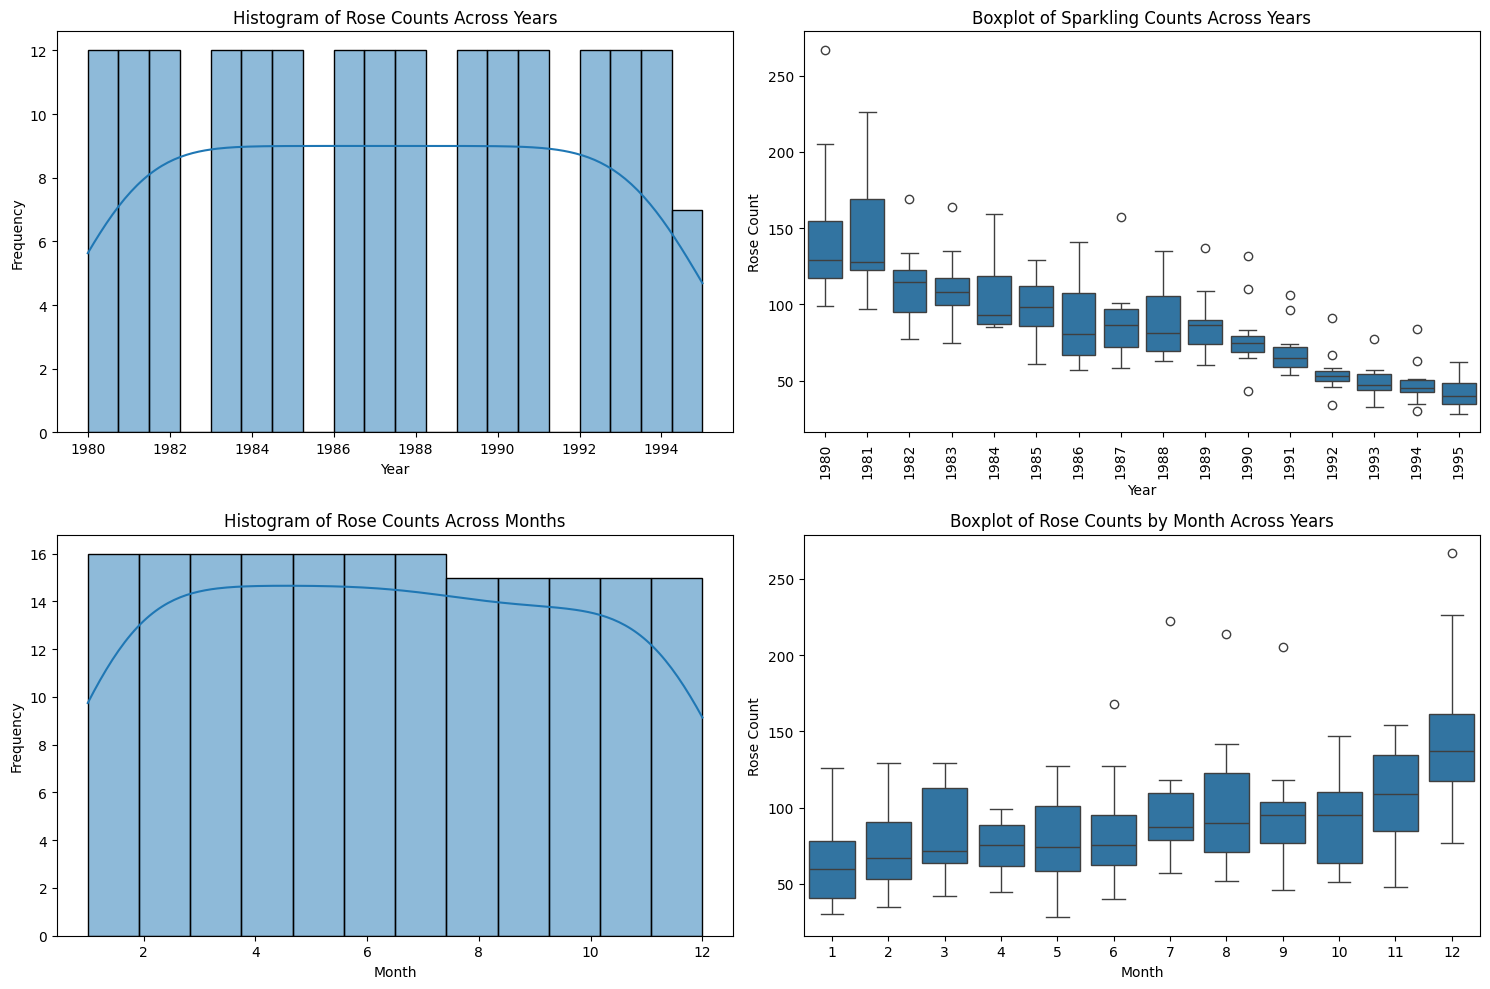

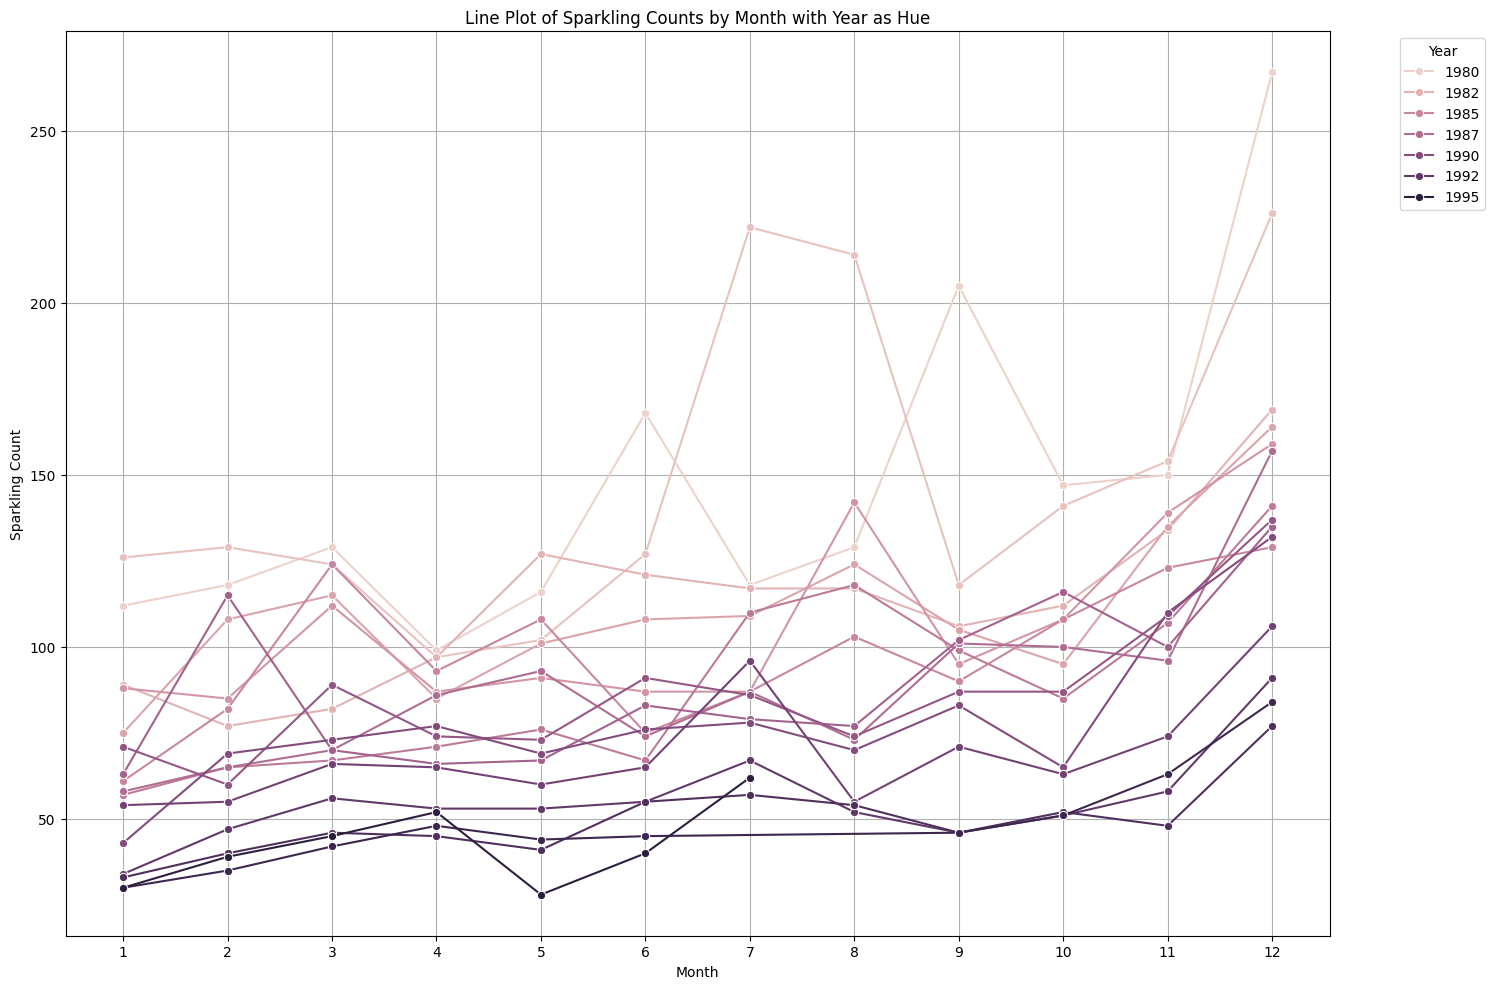

In [10]:
# Histogram across years Sparkling

plt.figure(figsize=(15, 10))

# Histogram across years
plt.subplot(2, 2, 1)
sns.histplot(data=df_rose, x='Year', bins=20, kde=True)
plt.title('Histogram of Rose Counts Across Years')
plt.xlabel('Year')
plt.ylabel('Frequency')

# Boxplot across years
plt.subplot(2, 2, 2)
sns.boxplot(x='Year', y='Rose', data=df_rose)
plt.xticks(rotation=90)
plt.title('Boxplot of Sparkling Counts Across Years')
plt.xlabel('Year')
plt.ylabel('Rose Count')

# Histogram of same month across years
plt.subplot(2, 2, 3)
sns.histplot(data=df_rose, x='Month', bins=12, kde=True)
plt.title('Histogram of Rose Counts Across Months')
plt.xlabel('Month')
plt.ylabel('Frequency')

# Boxplot of same month across years
plt.subplot(2, 2, 4)
sns.boxplot(x='Month', y='Rose', data=df_rose)
plt.title('Boxplot of Rose Counts by Month Across Years')
plt.xlabel('Month')
plt.ylabel('Rose Count')
plt.tight_layout()
plt.savefig('./images/Hist_Box_Rose.svg')
plt.show()

# Trend of same month across years

plt.figure(figsize=(15, 10))
sns.lineplot(data=df_rose, x='Month', y='Rose', hue='Year', marker='o')
plt.title('Line Plot of Sparkling Counts by Month with Year as Hue')
plt.xlabel('Month')
plt.ylabel('Sparkling Count')
plt.xticks(range(1, 13))  # Set x-ticks to represent months
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('./images/line_Rose.svg')
plt.show()

In [11]:
# Check seasonality and trends using rolling statistics
df_sparkling['Sales_rolling_mean'] = df_sparkling['Sparkling'].rolling(window=12).mean()
df_sparkling['Sales_rolling_std'] = df_sparkling['Sparkling'].rolling(window=12).std()

df_rose['Sales_rolling_mean'] = df_rose['Rose'].rolling(window=12).mean()
df_rose['Sales_rolling_std'] = df_rose['Rose'].rolling(window=12).std()

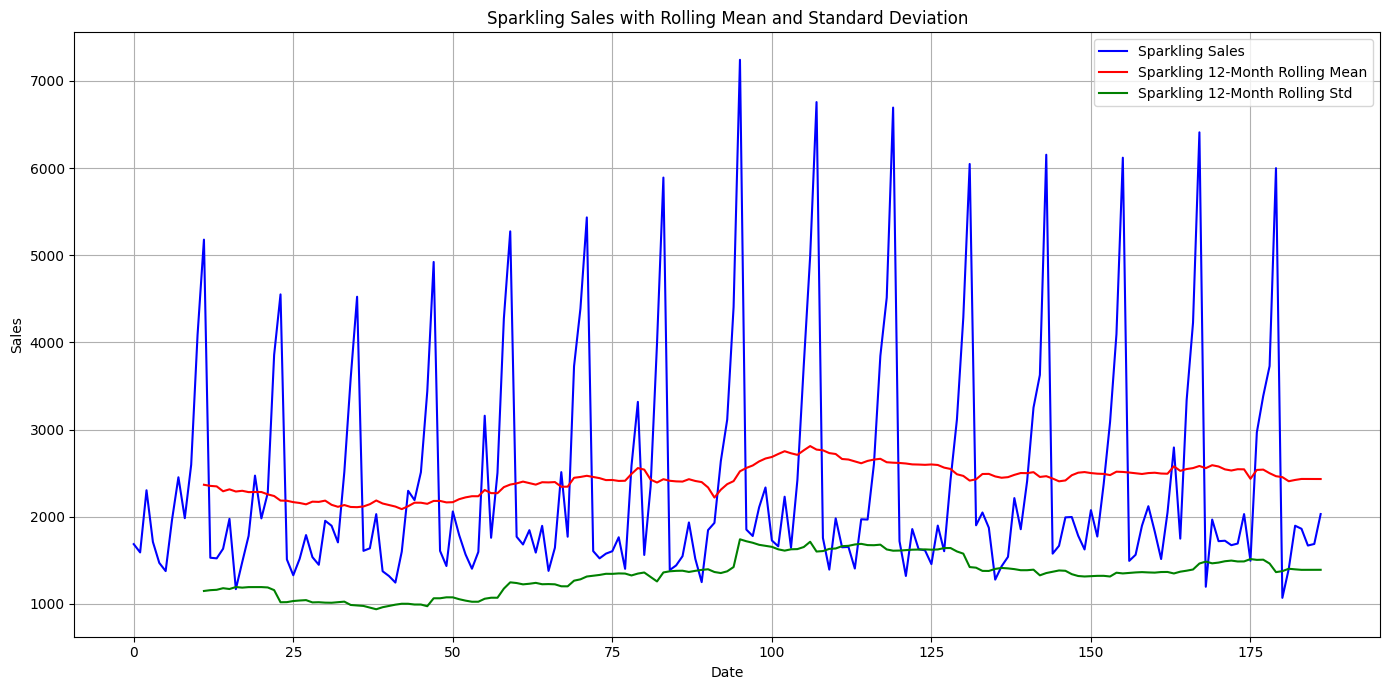

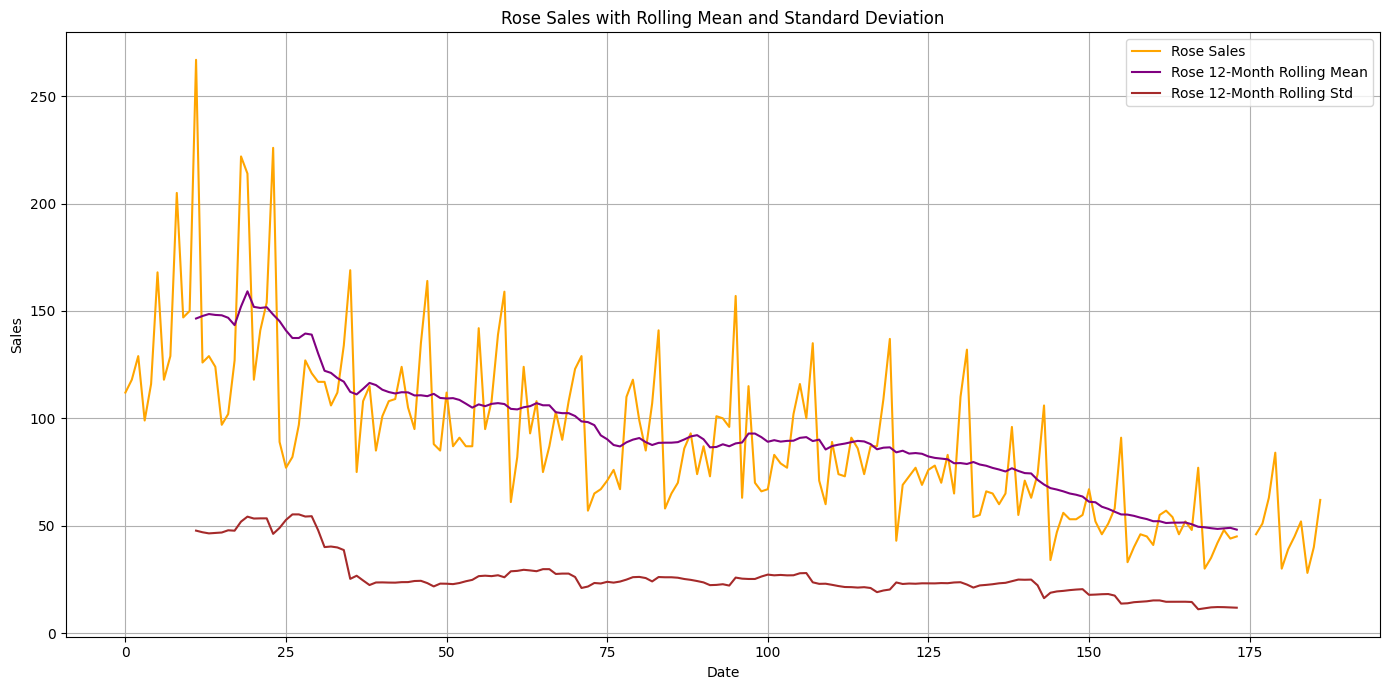

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(df_sparkling['Sparkling'], label='Sparkling Sales', color='blue')
plt.plot(df_sparkling['Sales_rolling_mean'], label='Sparkling 12-Month Rolling Mean', color='red')
plt.plot(df_sparkling['Sales_rolling_std'], label='Sparkling 12-Month Rolling Std', color='green')
plt.title('Sparkling Sales with Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./images/rolling_mean_std_sparkling.svg')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(df_rose['Rose'], label='Rose Sales', color='orange')
plt.plot(df_rose['Sales_rolling_mean'], label='Rose 12-Month Rolling Mean', color='purple')
plt.plot(df_rose['Sales_rolling_std'], label='Rose 12-Month Rolling Std', color='brown')
plt.title('Rose Sales with Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./images/rolling_mean_std_rose.svg')
plt.show()


### Perform Decomposition
- Decompose the time series to analyze trend, seasonality, and residual components for both datasets
    - Sparkling the Trend seem to be additive, at a period of 12
    - Rose the has missing values we would need to treat the same and then do decomposition.
    - Post handling of missing values when we do decomposition, it looks to be additive 

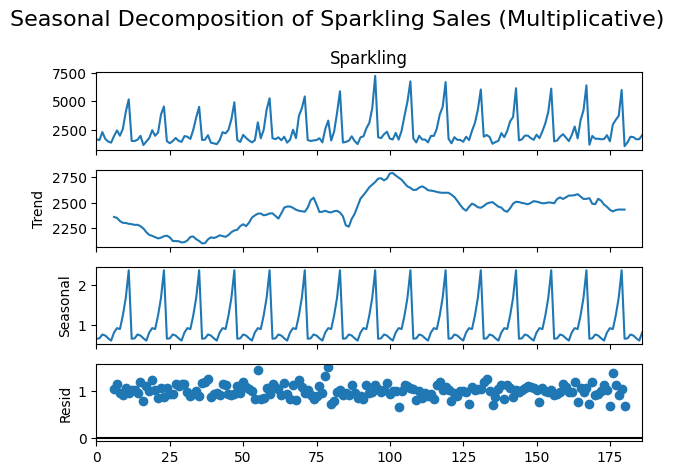

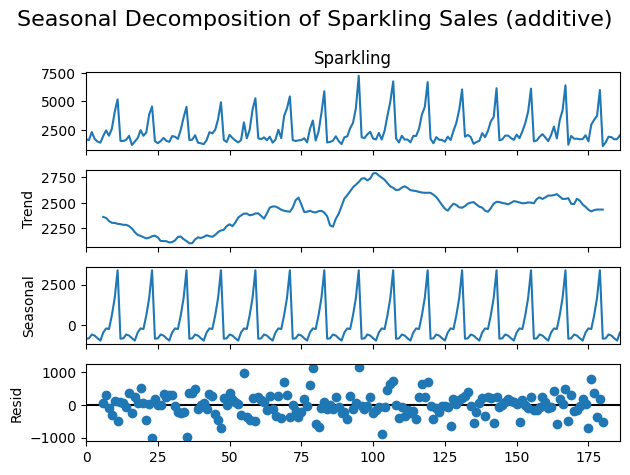

In [13]:
decompose_result_sparkling = seasonal_decompose(df_sparkling['Sparkling'], model='multiplicative', period=12)
decompose_result_sparkling.plot()
plt.suptitle('Seasonal Decomposition of Sparkling Sales (Multiplicative)', fontsize=16)
plt.tight_layout()
plt.savefig('./images/decomposition_sparkling_mult.svg')
plt.show()

decompose_result_sparkling = seasonal_decompose(df_sparkling['Sparkling'], model='additive', period=12)
decompose_result_sparkling.plot()
plt.suptitle('Seasonal Decomposition of Sparkling Sales (additive)', fontsize=16)
plt.tight_layout()
plt.savefig('./images/decomposition_sparkling_add.svg')
plt.show()

## Question 2: Data Pre-Processing
### Missing value treatment
- Sparkling does not have any missing values for sales.
- Rose has missing values for salse we will use ffill to correct this and then run, decomposition.

In [14]:
print(df_sparkling.isnull().sum())

YearMonth              0
Sparkling              0
Year                   0
Month                  0
Sales_rolling_mean    11
Sales_rolling_std     11
dtype: int64


In [15]:
print(df_rose.isnull().sum())

YearMonth              0
Rose                   2
Year                   0
Month                  0
Sales_rolling_mean    24
Sales_rolling_std     24
dtype: int64


In [16]:
# Forward fill to handle missing values 
df_rose['Rose'].fillna(method='ffill', inplace=True)

In [17]:
print("\nMissing Values after Treatment for Rose:")
print(df_rose['Rose'].isnull().sum())


Missing Values after Treatment for Rose:
0


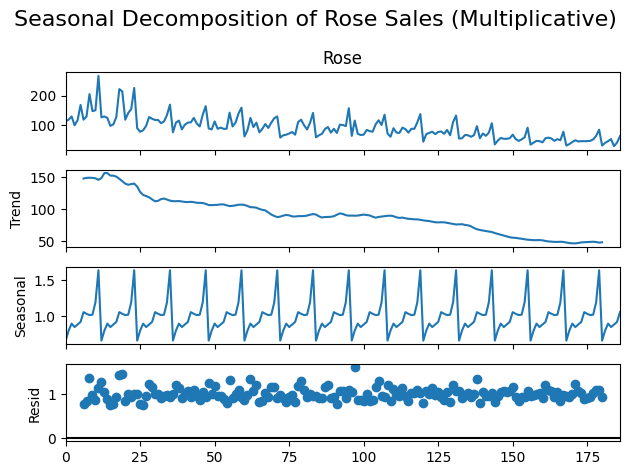

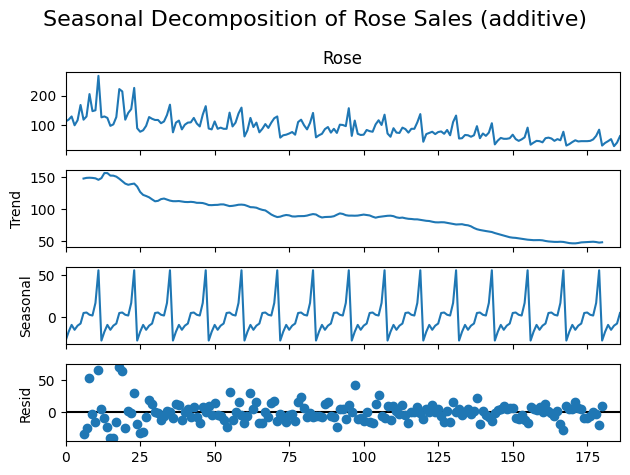

In [18]:
# Running Decomposition for Rose.
decompose_result_sparkling = seasonal_decompose(df_rose['Rose'], model='multiplicative', period=12)
decompose_result_sparkling.plot()
plt.suptitle('Seasonal Decomposition of Rose Sales (Multiplicative)', fontsize=16)
plt.tight_layout()
plt.savefig('./images/decomposition_rose_mult.svg')
plt.show()

decompose_result_sparkling = seasonal_decompose(df_rose['Rose'], model='additive', period=12)
decompose_result_sparkling.plot()
plt.suptitle('Seasonal Decomposition of Rose Sales (additive)', fontsize=16)
plt.tight_layout()
plt.savefig('./images/decomposition_rose_add.svg')
plt.show()

### Visualize the processed data

In [19]:
df_sparkling = df_sparkling.set_index(keys=['YearMonth'])
df_sparkling.head()

,Sparkling,Year,Month,Sales_rolling_mean,Sales_rolling_std
YearMonth,,,,,
1980-01-01,1686,1980,1,NaN,NaN
1980-02-01,1591,1980,2,NaN,NaN
1980-03-01,2304,1980,3,NaN,NaN
1980-04-01,1712,1980,4,NaN,NaN
1980-05-01,1471,1980,5,NaN,NaN


In [20]:
df_rose = df_rose.set_index(keys=['YearMonth'])
df_rose.head()


,Rose,Year,Month,Sales_rolling_mean,Sales_rolling_std
YearMonth,,,,,
1980-01-01,112.0,1980,1,NaN,NaN
1980-02-01,118.0,1980,2,NaN,NaN
1980-03-01,129.0,1980,3,NaN,NaN
1980-04-01,99.0,1980,4,NaN,NaN
1980-05-01,116.0,1980,5,NaN,NaN


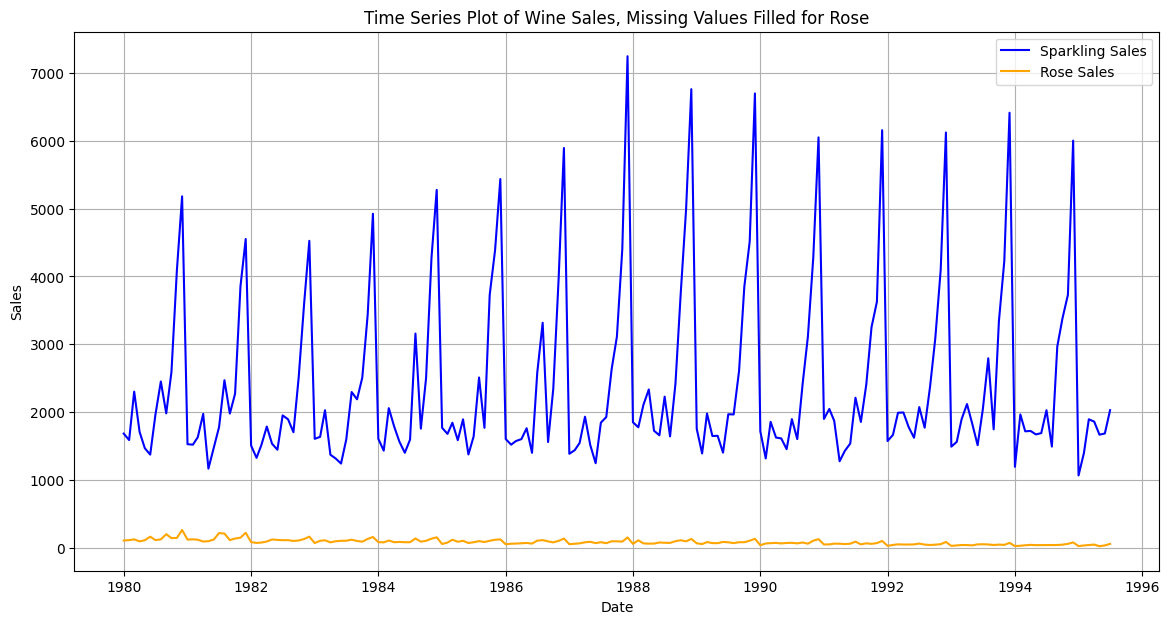

In [21]:
# see now there is no missing values for Rose and the values from the pervious month are filled in
plt.figure(figsize=(14, 7))
plt.plot(df_sparkling['Sparkling'], label='Sparkling Sales', color='blue')
plt.plot(df_rose['Rose'], label='Rose Sales', color='orange')
plt.title('Time Series Plot of Wine Sales, Missing Values Filled for Rose')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.savefig('./images/Time_Plot_corrected_all.svg')
plt.show()

### Train-Test Split
-We split the dataset in a 70-30 ratio along the timeline.
-This gives us 130 observations in train data and 57 observations in test data

In [22]:
df_sparkling.drop(columns=['Year','Month','Sales_rolling_mean','Sales_rolling_std'],inplace=True)
train_size_sparkling = int(len(df_sparkling) * 0.7)
train_sparkling, test_sparkling = df_sparkling[:train_size_sparkling], df_sparkling[train_size_sparkling:]


In [23]:
df_rose.drop(columns=['Year','Month','Sales_rolling_mean','Sales_rolling_std'],inplace=True)
train_size_rose = int(len(df_rose) * 0.7)
train_rose, test_rose = df_rose[:train_size_rose], df_rose[train_size_rose:]

In [24]:
print(f'The # of observations in train_sparkling are: {len(train_sparkling)}')
print(f'The # of observations in test_sparkling are: {len(test_sparkling)}')
print(f'The # of observations in train_rose are: {len(train_rose)}')
print(f'The # of observations in test_rose are: {len(test_rose)}')

The # of observations in train_sparkling are: 130
The # of observations in test_sparkling are: 57
The # of observations in train_rose are: 130
The # of observations in test_rose are: 57


## Question 3: Model Building - Original Data

### 1. Linear Regression Model

In [25]:
X_train_sparkling = np.array(range(len(train_sparkling))).reshape(-1, 1)
y_train_sparkling = train_sparkling['Sparkling'].values
X_test_sparkling = np.array(range(len(train_sparkling), len(train_sparkling) + len(test_sparkling))).reshape(-1, 1)

In [26]:
X_train_rose = np.array(range(len(train_rose))).reshape(-1, 1)
y_train_rose = train_rose['Rose'].values
X_test_rose = np.array(range(len(train_rose), len(train_rose) + len(test_rose))).reshape(-1, 1)

In [27]:
# Build Linear Regression models
lr_model_sparkling = LinearRegression().fit(X_train_sparkling, y_train_sparkling)
lr_forecast_sparkling = lr_model_sparkling.predict(X_test_sparkling)

lr_model_rose = LinearRegression().fit(X_train_rose, y_train_rose)
lr_forecast_rose = lr_model_rose.predict(X_test_rose)

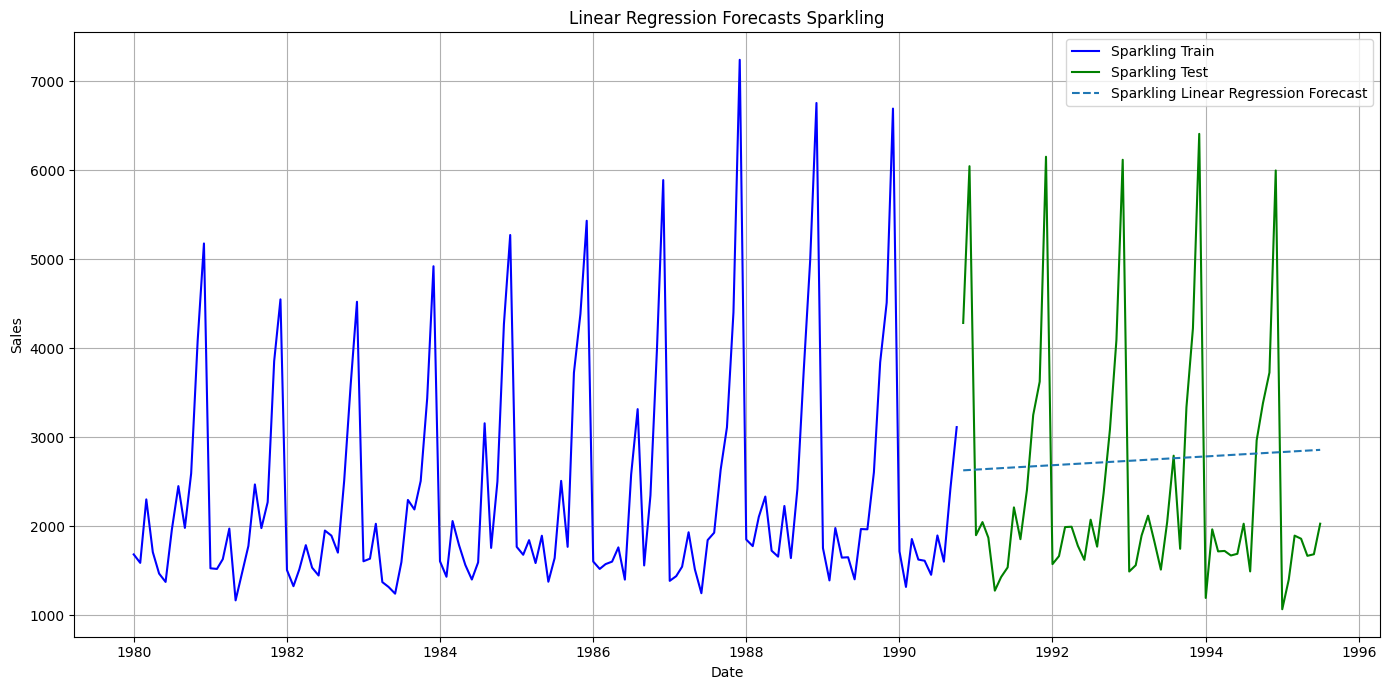

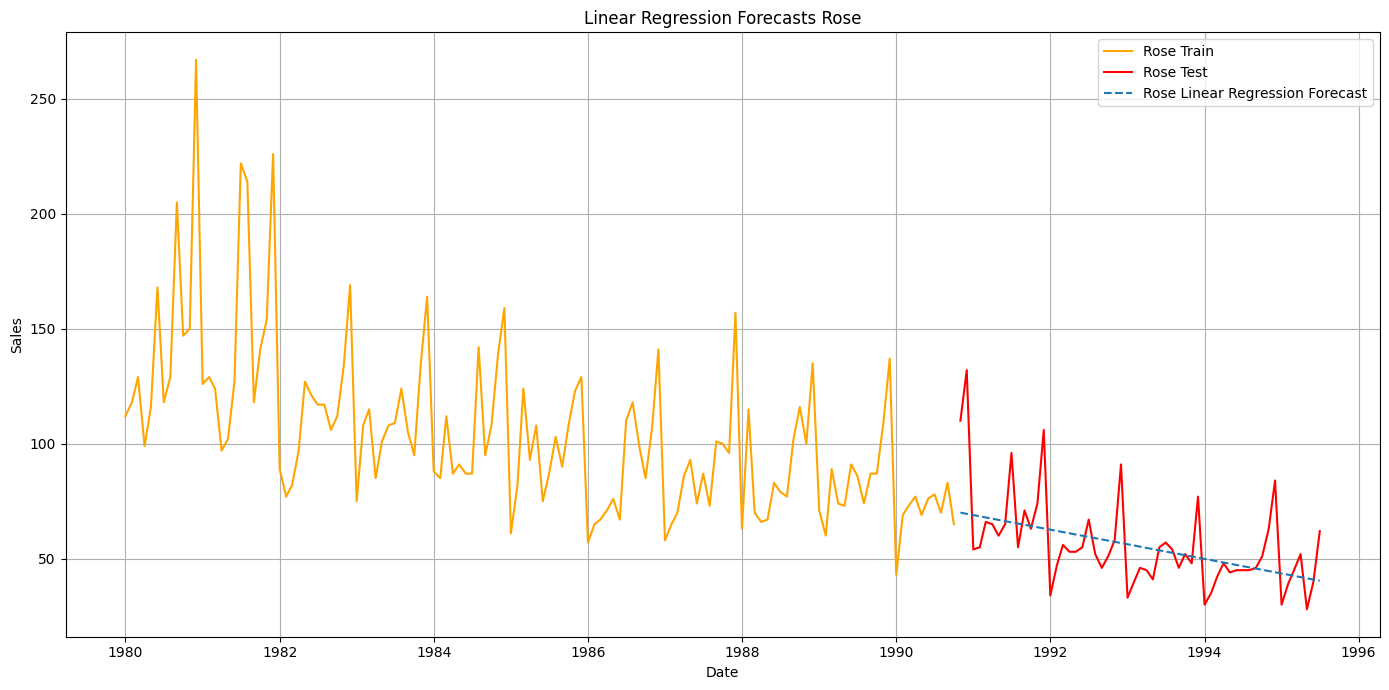

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(train_sparkling['Sparkling'], label='Sparkling Train', color='blue')
plt.plot(test_sparkling['Sparkling'], label='Sparkling Test', color='green')
plt.plot(test_sparkling.index, lr_forecast_sparkling, label='Sparkling Linear Regression Forecast', linestyle='--')
plt.title('Linear Regression Forecasts Sparkling')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./images/lr_forcast_spark.svg')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(train_rose['Rose'], label='Rose Train', color='orange')
plt.plot(test_rose['Rose'], label='Rose Test', color='red')
plt.plot(test_rose.index, lr_forecast_rose, label='Rose Linear Regression Forecast', linestyle='--')

plt.title('Linear Regression Forecasts Rose')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./images/lr_forcast_rose.svg')
plt.show()

### 2. Simple Average Model

In [29]:
simple_avg_forecast_sparkling = [train_sparkling['Sparkling'].mean()] * len(test_sparkling)
simple_avg_forecast_rose = [train_rose['Rose'].mean()] * len(test_rose)

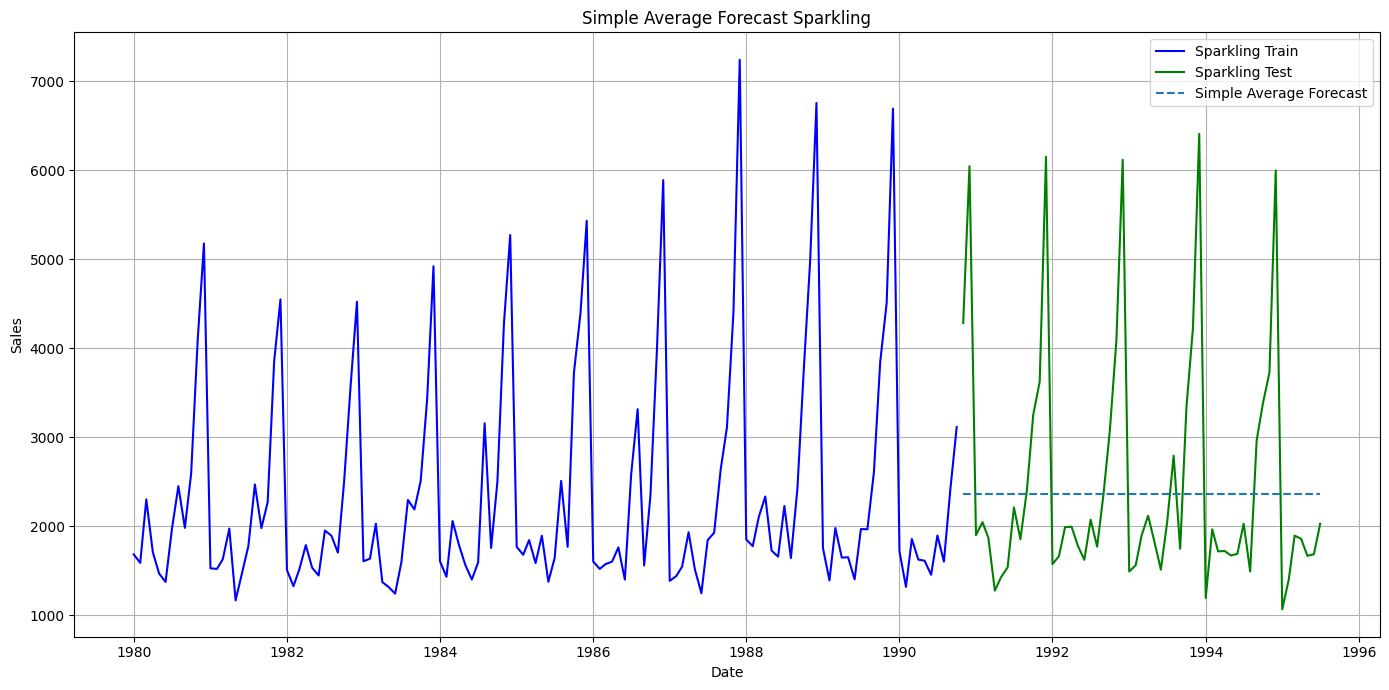

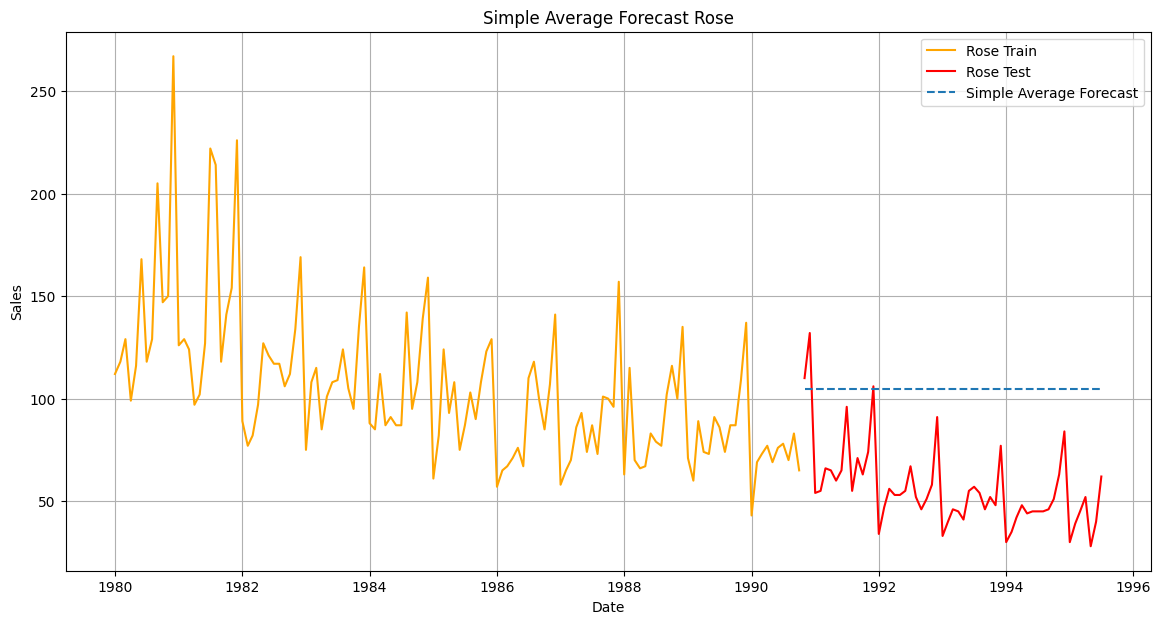

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(train_sparkling['Sparkling'], label='Sparkling Train', color='blue')
plt.plot(test_sparkling['Sparkling'], label='Sparkling Test', color='green')
plt.plot(test_sparkling.index, simple_avg_forecast_sparkling, label='Simple Average Forecast', linestyle='--')
plt.title('Simple Average Forecast Sparkling')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./images/sa_forcast_spark.svg')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(train_rose['Rose'], label='Rose Train', color='orange')
plt.plot(test_rose['Rose'], label='Rose Test', color='red')
plt.plot(test_rose.index, simple_avg_forecast_rose, label='Simple Average Forecast', linestyle='--')
plt.title('Simple Average Forecast Rose')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.savefig('./images/sa_forcast_rose.svg')
plt.show()


### 3. Moving Average Model

In [31]:
moving_avg_forecast_sparkling = train_sparkling['Sparkling'].rolling(window=3).mean().iloc[-1]
moving_avg_forecast_sparkling_values = [moving_avg_forecast_sparkling] * len(test_sparkling)

moving_avg_forecast_rose = train_rose['Rose'].rolling(window=3).mean().iloc[-1]
moving_avg_forecast_rose_values = [moving_avg_forecast_rose] * len(test_rose)

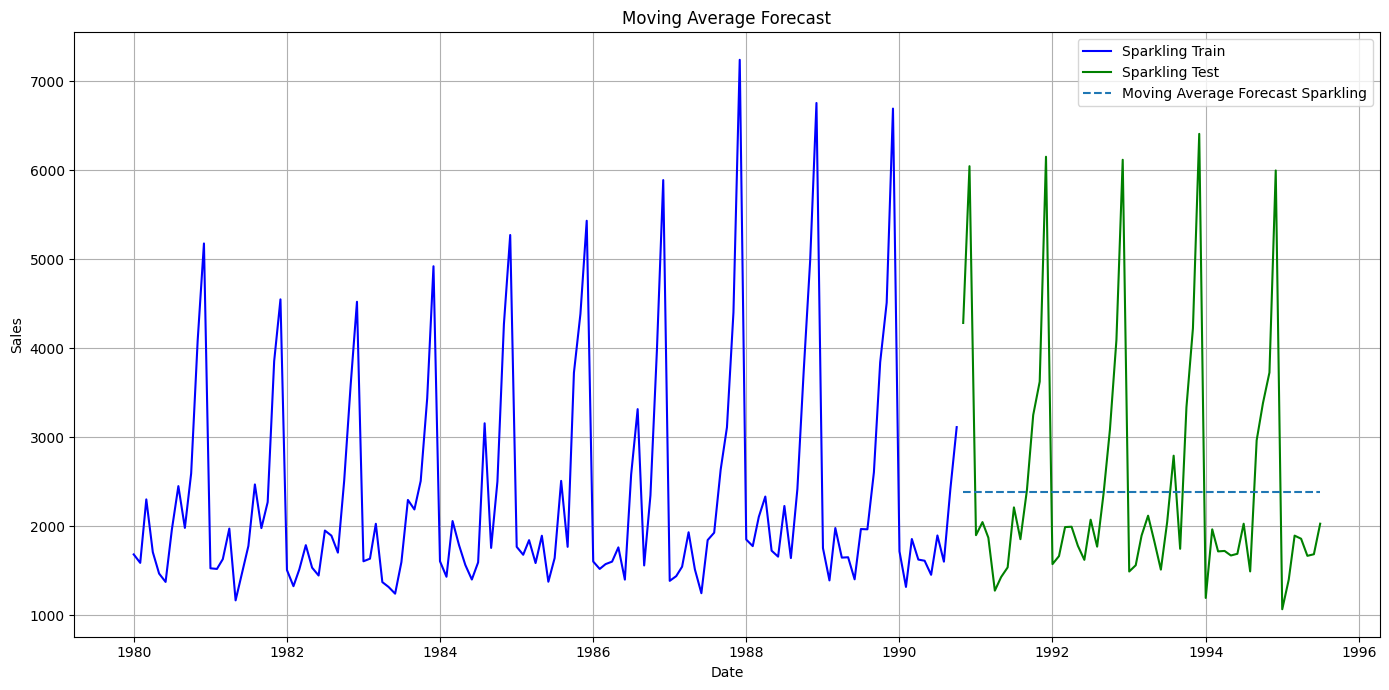

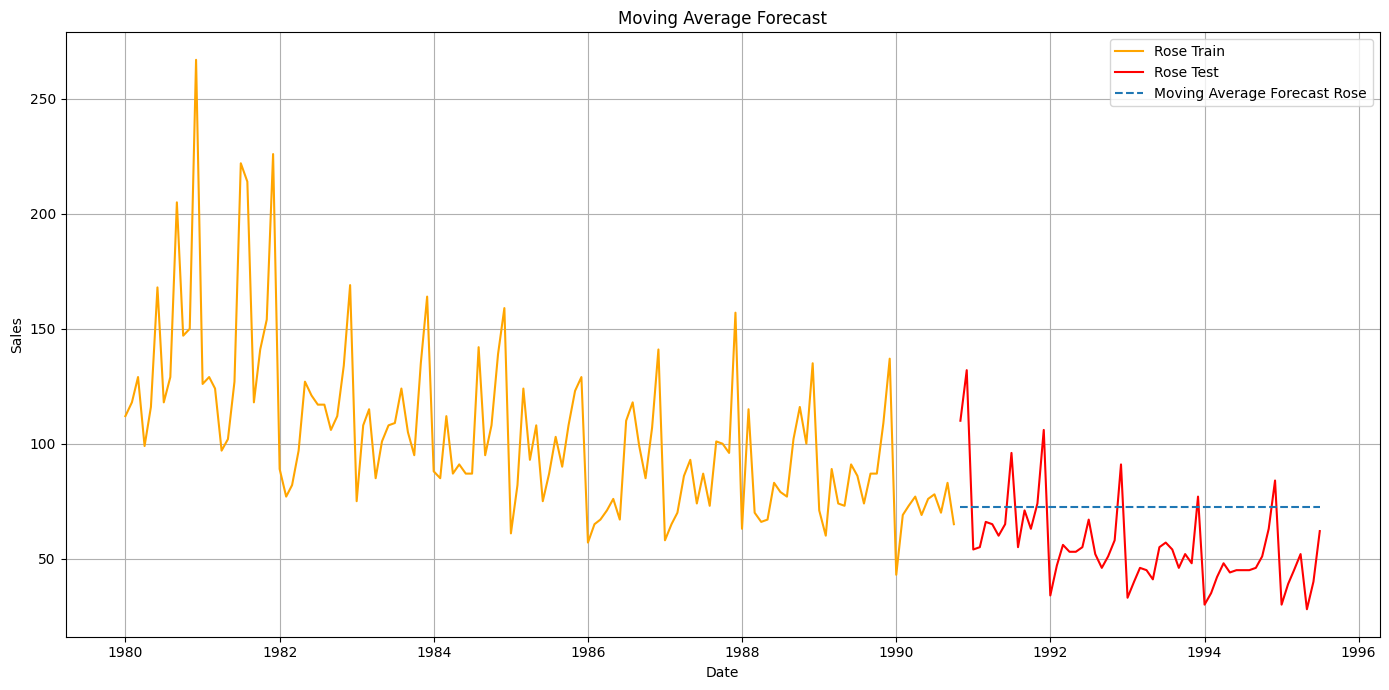

In [32]:
# Plotting Moving Average Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_sparkling['Sparkling'], label='Sparkling Train',color='blue')
plt.plot(test_sparkling['Sparkling'], label='Sparkling Test', color='green')
plt.plot(test_sparkling.index, moving_avg_forecast_sparkling_values, label='Moving Average Forecast Sparkling', linestyle='--')
plt.title('Moving Average Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./images/ma_forcast_spark.svg')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(train_rose['Rose'], label='Rose Train',color='orange')
plt.plot(test_rose['Rose'], label='Rose Test', color='red')
plt.plot(test_rose.index, moving_avg_forecast_rose_values, label='Moving Average Forecast Rose', linestyle='--')
plt.title('Moving Average Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./images/ma_forcast_rose.svg')
plt.show()

### 4. Exponential Smoothing Models (Single, Double, Triple)

#### Single Exponential Smoothing

In [33]:
single_exp_model_sparkling = ExponentialSmoothing(train_sparkling['Sparkling'], trend=None, seasonal=None).fit()
single_exp_forecast_sparkling = single_exp_model_sparkling.forecast(len(test_sparkling))

single_exp_model_rose = ExponentialSmoothing(train_rose['Rose'], trend=None, seasonal=None).fit()
single_exp_forecast_rose = single_exp_model_rose.forecast(len(test_rose))

#### Double Exponential Smoothing

In [34]:
double_exp_model_sparkling = ExponentialSmoothing(train_sparkling['Sparkling'], trend='add', seasonal=None).fit()
double_exp_forecast_sparkling = double_exp_model_sparkling.forecast(len(test_sparkling))

double_exp_model_rose = ExponentialSmoothing(train_rose['Rose'], trend='add', seasonal=None).fit()
double_exp_forecast_rose = double_exp_model_rose.forecast(len(test_rose))

#### Triple Exponential Smoothing (Holt-Winters method)

In [35]:
triple_exp_model_sparkling = ExponentialSmoothing(train_sparkling['Sparkling'], trend='add', seasonal='add', seasonal_periods=12).fit()
triple_exp_forecast_sparkling = triple_exp_model_sparkling.forecast(len(test_sparkling))

triple_exp_model_rose = ExponentialSmoothing(train_rose['Rose'], trend='add', seasonal='add', seasonal_periods=12).fit()
triple_exp_forecast_rose = triple_exp_model_rose.forecast(len(test_rose))

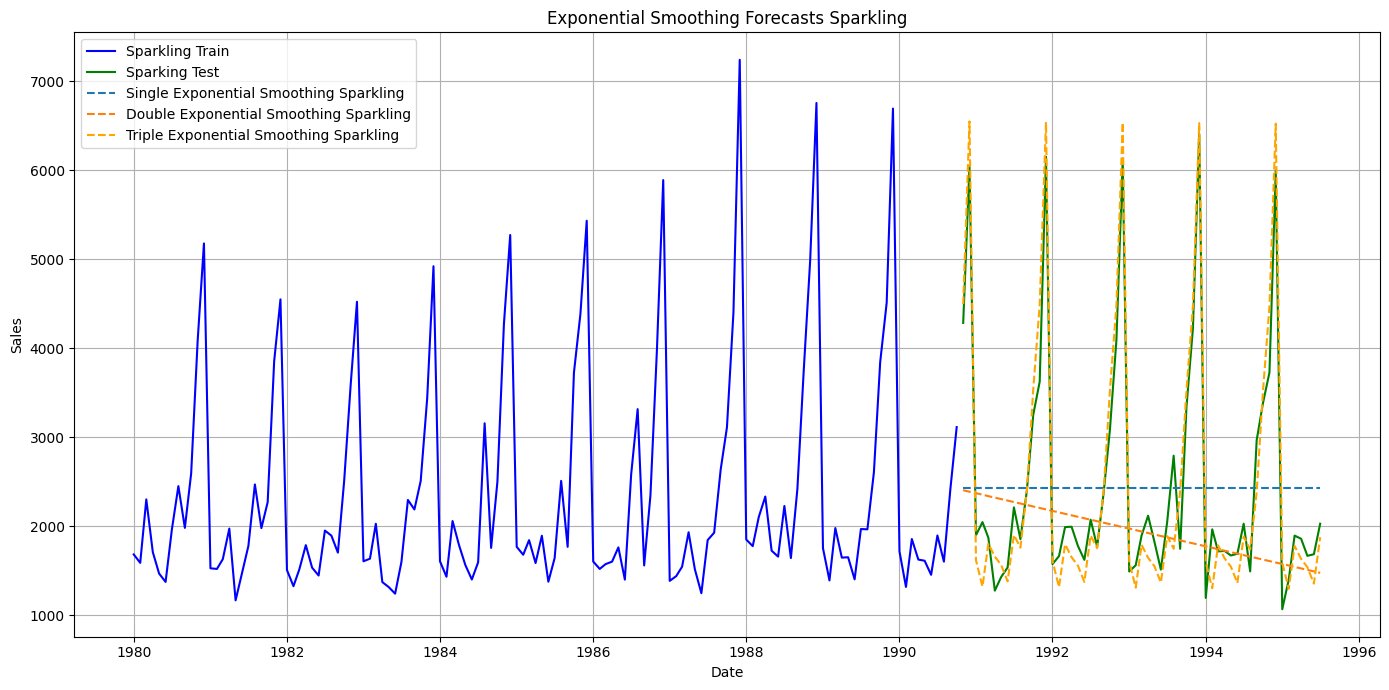

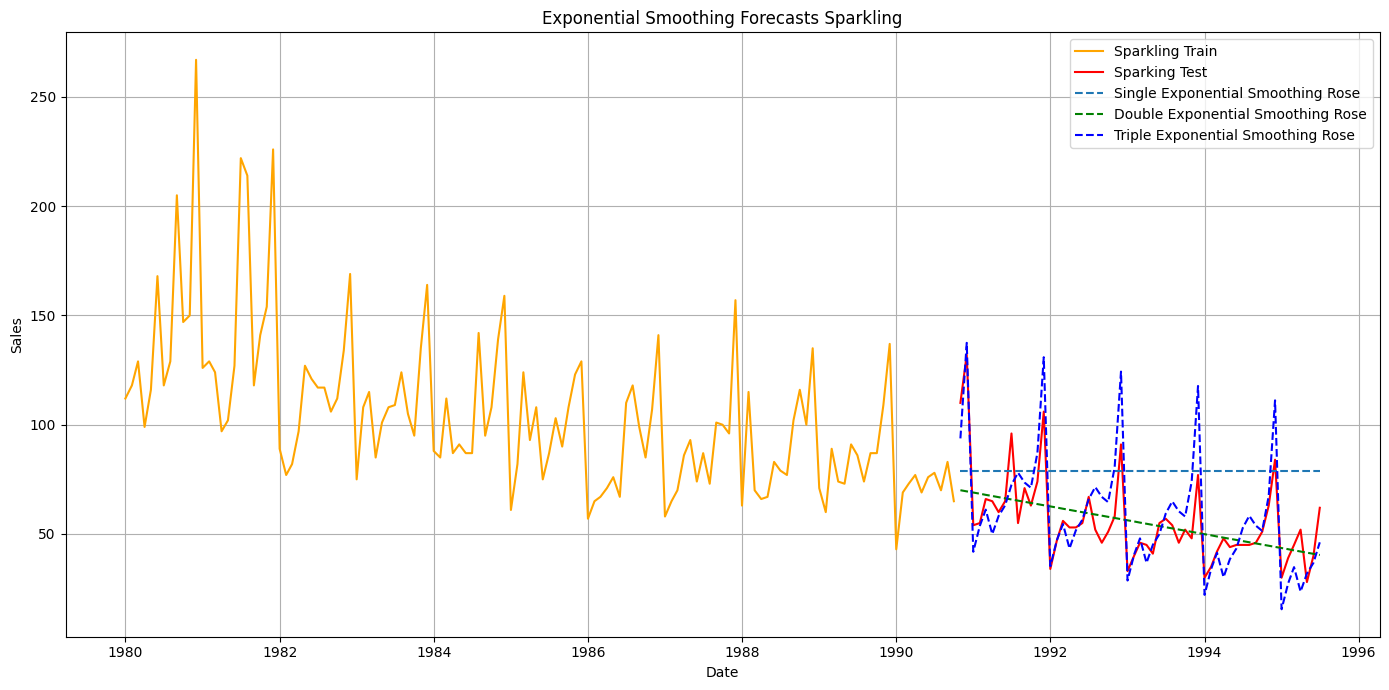

In [36]:
# Plotting Exponential Smoothing Forecasts
plt.figure(figsize=(14, 7))
plt.plot(train_sparkling['Sparkling'], label='Sparkling Train', color='blue')
plt.plot(test_sparkling['Sparkling'], label='Sparking Test', color='green')
plt.plot(test_sparkling.index, single_exp_forecast_sparkling, label='Single Exponential Smoothing Sparkling', linestyle='--')
plt.plot(test_sparkling.index, double_exp_forecast_sparkling, label='Double Exponential Smoothing Sparkling', linestyle='--')
plt.plot(test_sparkling.index, triple_exp_forecast_sparkling, label='Triple Exponential Smoothing Sparkling',color='orange', linestyle='--')
plt.title('Exponential Smoothing Forecasts Sparkling')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./images/exp_forcast_spark.svg')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(train_rose['Rose'], label='Sparkling Train', color='orange')
plt.plot(test_rose['Rose'], label='Sparking Test', color='red')
plt.plot(test_rose.index, single_exp_forecast_rose, label='Single Exponential Smoothing Rose', linestyle='--')
plt.plot(test_rose.index, double_exp_forecast_rose, label='Double Exponential Smoothing Rose', color='green',linestyle='--')
plt.plot(test_rose.index, triple_exp_forecast_rose, label='Triple Exponential Smoothing Rose',color='blue', linestyle='--')
plt.title('Exponential Smoothing Forecasts Sparkling')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./images/exp_forcast_rose.svg')
plt.show()

### Check the performance of the models built

In [37]:
def evaluate_model(test, forecast, model_name):
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    print(f'{model_name} Performance: MSE={mse:.4f}, MAE={mae:.4f}')

evaluate_model(test_sparkling['Sparkling'], lr_forecast_sparkling, "Linear Regression for Sparking Wine.")
evaluate_model(test_sparkling['Sparkling'], simple_avg_forecast_sparkling, "Simple Average for Sparking Wine.")
evaluate_model(test_sparkling['Sparkling'], moving_avg_forecast_sparkling_values, "Moving Average for Sparking Wine.")
evaluate_model(test_sparkling['Sparkling'], single_exp_forecast_sparkling, "Single Exponential Smoothing for Sparking Wine.")
evaluate_model(test_sparkling['Sparkling'], double_exp_forecast_sparkling, "Double Exponential Smoothing for Sparking Wine.")
evaluate_model(test_sparkling['Sparkling'], triple_exp_forecast_sparkling, "Triple Exponential Smoothing for Sparking Wine.")

Linear Regression for Sparking Wine. Performance: MSE=1938884.4329, MAE=1148.3683
Simple Average for Sparking Wine. Performance: MSE=1873467.5749, MAE=980.8915
Moving Average for Sparking Wine. Performance: MSE=1868379.3626, MAE=988.5673
Single Exponential Smoothing for Sparking Wine. Performance: MSE=1859686.7840, MAE=1008.6860
Double Exponential Smoothing for Sparking Wine. Performance: MSE=2167530.5824, MAE=896.3781
Triple Exponential Smoothing for Sparking Wine. Performance: MSE=134585.6401, MAE=292.0846


In [38]:
evaluate_model(test_rose['Rose'], lr_forecast_rose, "Linear Regression for Rose Wine.")
evaluate_model(test_rose['Rose'], simple_avg_forecast_rose, "Simple Average for Rose Wine.")
evaluate_model(test_rose['Rose'], moving_avg_forecast_rose_values, "Moving Average for Rose Wine.")
evaluate_model(test_rose['Rose'], single_exp_forecast_rose, "Single Exponential Smoothing for Rose Wine.")
evaluate_model(test_rose['Rose'], double_exp_forecast_rose, "Double Exponential Smoothing for Rose Wine.")
evaluate_model(test_rose['Rose'], triple_exp_forecast_rose, "Triple Exponential Smoothing for Rose Wine.")

Linear Regression for Rose Wine. Performance: MSE=301.2628, MAE=11.8906
Simple Average for Rose Wine. Performance: MSE=2749.1122, MAE=49.6896
Moving Average for Rose Wine. Performance: MSE=668.3099, MAE=23.0936
Single Exponential Smoothing for Rose Wine. Performance: MSE=912.5146, MAE=27.8154
Double Exponential Smoothing for Rose Wine. Performance: MSE=301.2628, MAE=11.8906
Triple Exponential Smoothing for Rose Wine. Performance: MSE=196.6170, MAE=10.3115


## Question 4: Check for Stationarity

### Check for stationarity using ADF Test

In [39]:
adf_result = adfuller(df_sparkling['Sparkling'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print(f'p-value is over 0.05, The Sparkling Wine Sales is non-sationary')

ADF Statistic: -1.3604974548123363
p-value: 0.6010608871634857
p-value is over 0.05, The Sparkling Wine Sales is non-sationary


In [40]:
adf_result = adfuller(df_rose['Rose'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print(f'p-value is over 0.05, The Rose Wine Sales is non-sationary')

ADF Statistic: -1.8748555417199897
p-value: 0.34398071933430396
p-value is over 0.05, The Rose Wine Sales is non-sationary


### Make the data stationary (if needed)

In [41]:
df_sparkling['Sales_diff'] = df_sparkling['Sparkling'].diff().dropna()
adf_result_diff = adfuller(df_sparkling['Sales_diff'].dropna())
print('ADF Statistic (after differencing):', adf_result_diff[0])
print('p-value (after differencing):', adf_result_diff[1])
print(f'p-value is less 0.05, The Sparkling Wine Sales is sationary with frist-order difference.')

ADF Statistic (after differencing): -45.05030093619529
p-value (after differencing): 0.0
p-value is less 0.05, The Sparkling Wine Sales is sationary with frist-order difference.


In [42]:
df_rose['Sales_diff'] = df_rose['Rose'].diff(7).dropna()
adf_result_diff = adfuller(df_rose['Sales_diff'].dropna())
print('ADF Statistic (after differencing):', adf_result_diff[0])
print('p-value (after differencing):', adf_result_diff[1])
print(f'p-value is less 0.05, The Sparkling Wine Sales is sationary with 7th-order difference.')

ADF Statistic (after differencing): -3.845064236444696
p-value (after differencing): 0.002478477502772531
p-value is less 0.05, The Sparkling Wine Sales is sationary with 7th-order difference.


## Question 5: Model Building - Stationary Data

### Generate ACF & PACF Plot and Find AR, MA values

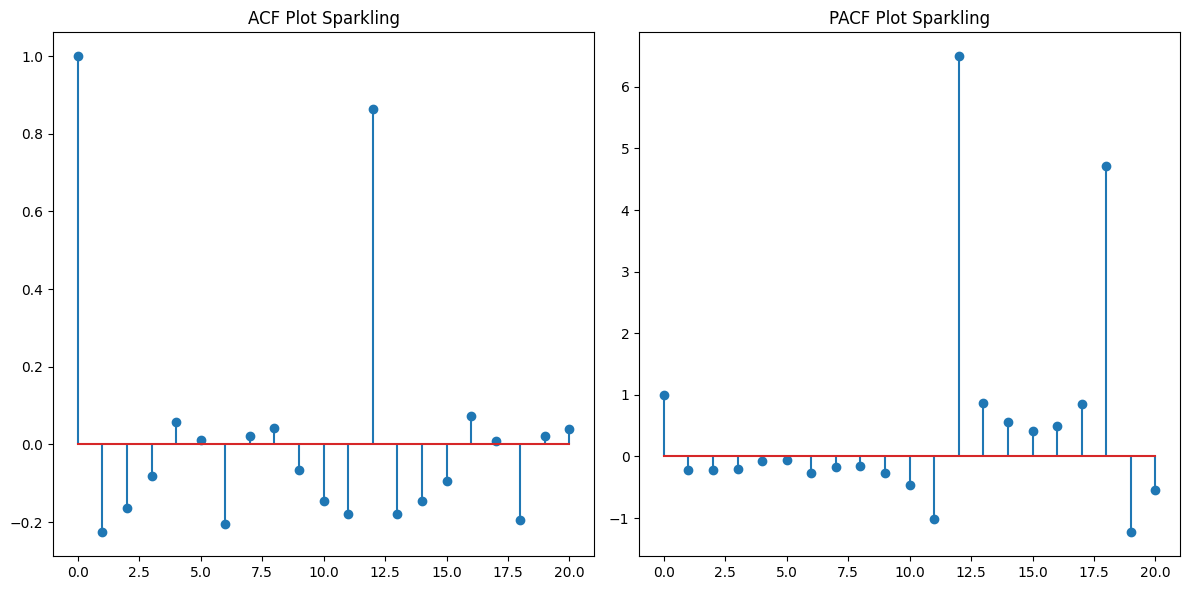

ACF Plot Shows spikes at: 1,2,6,11,12,13,14,18 for Sparkling
PACF Plot Shows spikes at: 10,11,12,18,19 for Sparkling


In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.stem(acf(df_sparkling['Sales_diff'].dropna(), nlags=20))
plt.title('ACF Plot Sparkling')
plt.subplot(122)
plt.stem(pacf(df_sparkling['Sales_diff'].dropna(), nlags=20))
plt.title('PACF Plot Sparkling')
plt.tight_layout()
plt.savefig('./images/acf_pacf_spark.svg')
plt.show()

print('ACF Plot Shows spikes at: 1,2,6,11,12,13,14,18 for Sparkling')
print('PACF Plot Shows spikes at: 10,11,12,18,19 for Sparkling')

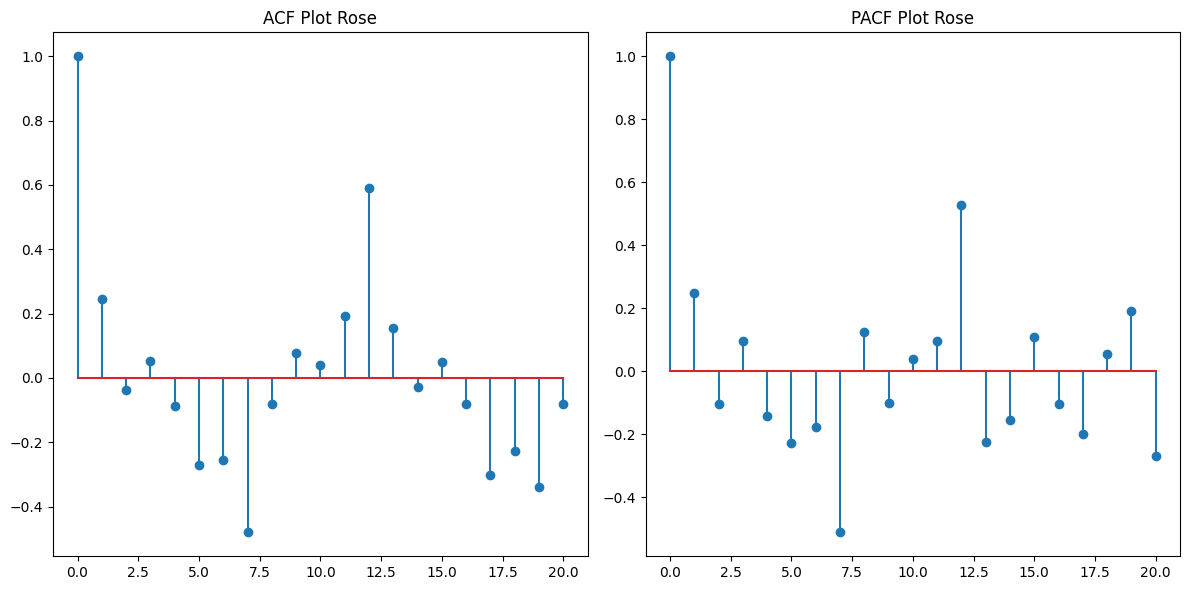

ACF Plot Shows spikes at: 1,5,6,7,11,12,17,18,19 for Rose
PACF Plot Shows spikes at: 1,5,6,7,12,13,14,17,19,20 for Rose


In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.stem(acf(df_rose['Sales_diff'].dropna(), nlags=20))
plt.title('ACF Plot Rose')
plt.subplot(122)
plt.stem(pacf(df_rose['Sales_diff'].dropna(), nlags=20))
plt.title('PACF Plot Rose')
plt.tight_layout()
plt.savefig('./images/acf_pacf_rose.svg')
plt.show()

print('ACF Plot Shows spikes at: 1,5,6,7,11,12,17,18,19 for Rose')
print('PACF Plot Shows spikes at: 1,5,6,7,12,13,14,17,19,20 for Rose')

### Build different ARIMA models

#### Build Auto ARIMA model

In [45]:
auto_arima_model_sparkling = auto_arima(train_sparkling['Sparkling'], seasonal=False, trace=True, suppress_warnings=True, stepwise=True)
auto_arima_model_sparkling.fit(train_sparkling['Sparkling'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2422.783, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2244.390, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2331.596, Time=0.59 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2244.916, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2242.972, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=2.37 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=1.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2291.309, Time=1.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2206.535, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2205.446, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2228.475, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2206.008, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2207.502, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2207.4

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True)

In [46]:
auto_arima_model_sparkling = ARIMA(train_sparkling['Sparkling'], order=(0,0,1))
auto_arima_model_sparkling_fit = auto_arima_model_sparkling.fit()
auto_arima_sparkling_forecast = auto_arima_model_sparkling_fit.forecast(steps=len(test_sparkling))
mse = mean_squared_error(test_sparkling['Sparkling'],auto_arima_sparkling_forecast)
print(f'auto_arima_sparkling_forecast MSE: {mse}')

auto_arima_sparkling_forecast MSE: 1857117.2547485947


In [47]:
auto_arima_model_rose = auto_arima(train_rose['Rose'], seasonal=False, trace=True, suppress_warnings=True, stepwise=True)
auto_arima_model_rose.fit(train_rose['Rose'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1315.165, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1299.056, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1313.176, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1280.082, Time=0.52 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1278.774, Time=0.72 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1277.586, Time=0.69 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1279.302, Time=1.45 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1275.676, Time=0.83 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1276.843, Time=0.55 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1277.406, Time=0

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [48]:
auto_arima_model_rose = ARIMA(train_rose['Rose'], order=(0,1,2))
auto_arima_model_rose_fit = auto_arima_model_rose.fit()
auto_arima_rose_forecast = auto_arima_model_rose_fit.forecast(steps=len(test_rose))
mse = mean_squared_error(test_rose['Rose'],auto_arima_rose_forecast)
print(f'auto_arima_rose_forecast MSE: {mse}')

auto_arima_rose_forecast MSE: 956.2551839076006


#### Manual ARIMA Model

In [49]:
import warnings
warnings.filterwarnings("ignore")
# for Sparkling d = 1 to make it stationary
d = 1
# p is any of these values 1,2,6,11,12,13,14,18 since these are a lot of values for this exercise only the frist 3
p_list = [1,2,6,11,12,13,14,18]
# q list is any of these values 10,11,12,18,19 since these are a lot of values for this exercise only the frist 3
q_list = [10,11,12,18,19]

manual_arima_spark = None
optimal_mse = 99999999
optimal_p = None
optimal_q = None

# find the optimal p and q
for p in p_list:
    for q in q_list:
        try:
            manual_arima_spark = ARIMA(train_sparkling['Sparkling'], order=(p,d,q))
            manual_arima_spark_fit = manual_arima_spark.fit()
            manual_arima_spark_forecast = manual_arima_spark_fit.forecast(steps=len(test_sparkling))
            mse = mean_squared_error(test_sparkling['Sparkling'],manual_arima_spark_forecast)
            if optimal_mse > mse:
                optimal_mse = mse
                optimal_p = p
                optimal_q = q
        except (ValueError, np.linalg.LinAlgError) as e:
            print(f"Error with ARIMA(p={p}, d={d}, q={q}): {e}")
            continue
print(f'Optimal MSE: {optimal_mse}, Optimal p,d,q:{optimal_p,d,optimal_q}')
# Optimal MSE: 138228.02781707534, Optimal p,d,q:(12, 1, 12)
        


KeyboardInterrupt: 

In [ ]:
# for Rose d = 7 to make it stationary
d = 7
# p is any of these values 1,5,6,7,11,12,17,18,19 since these are a lot of values for this exercise only the 4 random values
p_list = [1,5,6,7,11]
# q list is any of these values 1,5,6,7,12,13,14,17,19,20 since these are a lot of values for this exercise only the 4 random values
q_list = [1,6,7,12]

manual_arima_rose = None
optimal_mse = 99999999
optimal_p = None
optimal_q = None

# find the optimal p and q
for p in p_list:
    for q in q_list:
        try:
            manual_arima_rose = ARIMA(train_rose['Rose'], order=(p,d,q))
            manual_arima_rose_fit = manual_arima_rose.fit()
            manual_arima_rose_forecast = manual_arima_rose_fit.forecast(steps=len(test_rose))
            mse = mean_squared_error(test_rose['Rose'],manual_arima_rose_forecast)
            if optimal_mse > mse:
                optimal_mse = mse
                optimal_p = p
                optimal_q = q
        except (ValueError, np.linalg.LinAlgError) as e:
            print(f"Error with ARIMA(p={p}, d={d}, q={q}): {e}")
            continue
print(f'Optimal MSE: {optimal_mse}, Optimal p,d,q:{optimal_p,d,optimal_q}')
# Optimal MSE: 112859.47259326068, Optimal p,d,q:(5, 7, 6)

#### Build Auto SARIMA model

In [ ]:
auto_sarima_model_sparkling = auto_arima(train_sparkling['Sparkling'], seasonal=True, trace=True, suppress_warnings=True, stepwise=True)
auto_sarima_model_sparkling.fit(train_sparkling['Sparkling'])

In [ ]:
auto_sarima_model_sparkling = ARIMA(train_sparkling['Sparkling'], order=(0,0,1),seasonal_order=(0,0,0,0))
auto_sarima_model_sparkling_fit = auto_sarima_model_sparkling.fit()
auto_sarima_spark_forecast = auto_sarima_model_sparkling_fit.forecast(steps=len(test_sparkling))
mse = mean_squared_error(test_sparkling['Sparkling'],auto_sarima_spark_forecast)
print(f'auto_sarima_spark_forecast MSE: {mse}')

In [ ]:
auto_sarima_model_rose = auto_arima(train_rose['Rose'], seasonal=True, trace=True, suppress_warnings=True, stepwise=True)
auto_sarima_model_rose.fit(train_rose['Rose'])

In [ ]:
auto_sarima_model_rose = ARIMA(train_rose['Rose'], order=(0,1,2),seasonal_order=(0,0,0,0))
auto_sarima_model_rose_fit = auto_sarima_model_rose.fit()
auto_sarima_rose_forecast = auto_sarima_model_rose_fit.forecast(steps=len(test_rose))
mse = mean_squared_error(test_rose['Rose'],auto_sarima_rose_forecast)
print(f'auto_sarima_rose_forecast MSE: {mse}')

#### Build Manual SARIMA model

In [ ]:
#### Kept running did not complete

# # for Sparkling d = 1 to make it stationary
# d = 1
# D = 1
# # p is any of these values 1,2,6,11,12,13,14,18 since these are a lot of values for this exercise with only 2
# p_list = [1,2]
# P_list = [1,2]
# # q list is any of these values 10,11,12,18,19 since these are a lot of values for this exercise owith only 2
# q_list = [10,11]
# Q_list = [10,11]
# s=12

# manual_sarima_spark = None
# optimal_mse = 99999999
# optimal_p = None
# optimal_q = None
# optimal_P = None
# optimal_Q = None

# # find the optimal p,q and P,Q
# for p in p_list:
#     for q in q_list:
#         for P in P_list:
#             for Q in Q_list:
#                 try:
#                     manual_sarima_spark = ARIMA(train_sparkling['Sparkling'], order=(p,d,q),seasonal_order=(P,D,Q,s))
#                     manual_sarima_spark_fit = manual_sarima_spark.fit()
#                     manual_sarima_spark_forecast = manual_sarima_spark_fit.forecast(steps=len(test_sparkling))
#                     mse = mean_squared_error(test_sparkling['Sparkling'],manual_arima_spark_forecast)
#                     if optimal_mse > mse:
#                         optimal_mse = mse
#                         optimal_p = p
#                         optimal_q = q
#                 except (ValueError, np.linalg.LinAlgError) as e:
#                     print(f"Error with ARIMA(p={p}, d={d}, q={q}): {e}")
#                     continue
# print(f'Optimal MSE: {optimal_mse}, Optimal p,d,q,P,D,Q,S:{optimal_p,d,optimal_q,optimal_P,D,optimal_Q,s}')
# # Optimal MSE: 138228.02781707534, Optimal p,d,q:(12, 1, 12)

### MANUAL SARIMA is taking to long so skiping this

## Question 6:  Compare the performance of the models

### From comparing all the MSE between the models that completed.
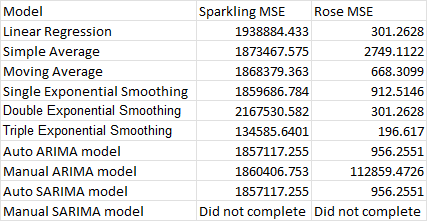!

The Double Exponential Smoothing model is good for Rose and the Triple Exponential Smoothing is good for the Sparkling as these have the least MSE, amount the models that ran